# Imports   

Let's do a few imports to start, if you running on colab, you'll need to pip install captum. 

If you are using your own environment, you may need to install other libraries.

In [1]:
#pip install captum

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.linear_model import SGDClassifier
from captum.attr import LayerGradientXActivation
import random
from PIL import Image
import matplotlib.pyplot as plt

import requests
from io import BytesIO

import glob
import kagglehub

import shutil


/home/raph2268/anaconda3/envs/XAI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# What's TCAV ?

<img src="data_tcav/_TCAV.png" >


# Gathering the data
Concretely, the first thing to do is gathering the data!
For computing TCAV, in addition to our dataset on which our model is trained, we need three other sets:
- The <b>concept set</b>: contains 30 to 100 images that will be used to fit our concept activation vector.<br>
- The <b>random set</b>: contains roughly the same amount of image as the concept set, these are the random images that will be use to train the linear classifier from which we will infer the CAV. <br>
- The <b>target set</b>: contains the images that we wish to evaluate our concept on. It can be a part of your test set<br>

In [3]:

def preview_image(image_path):
    image_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]

    # Limit to first 40 images
    image_files = image_files[:40]

    # Set up a grid size (e.g., 5x8 grid for 40 images)
    fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(15, 10))

    # Loop through images and plot them
    for i, ax in enumerate(axes.flat):
        if i < len(image_files):
            img_path = os.path.join(image_path, image_files[i])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')  # Hide axes

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

## Random images

Saved img_0.jpg
Saved img_1.jpg
Saved img_2.jpg
Saved img_3.jpg
Saved img_4.jpg
Saved img_5.jpg
Saved img_6.jpg
Saved img_7.jpg
Saved img_8.jpg
Saved img_9.jpg
Saved img_10.jpg
Saved img_11.jpg
Saved img_12.jpg
Saved img_13.jpg
Saved img_14.jpg
Saved img_15.jpg
Saved img_16.jpg
Saved img_17.jpg
Saved img_18.jpg
Saved img_19.jpg
Saved img_20.jpg
Saved img_21.jpg
Saved img_22.jpg
Saved img_23.jpg
Saved img_24.jpg
Saved img_25.jpg
Saved img_26.jpg
Saved img_27.jpg
Saved img_28.jpg
Saved img_29.jpg
Saved img_30.jpg
Saved img_31.jpg
Saved img_32.jpg
Saved img_33.jpg
Saved img_34.jpg
Saved img_35.jpg
Saved img_36.jpg
Saved img_37.jpg
Saved img_38.jpg
Saved img_39.jpg


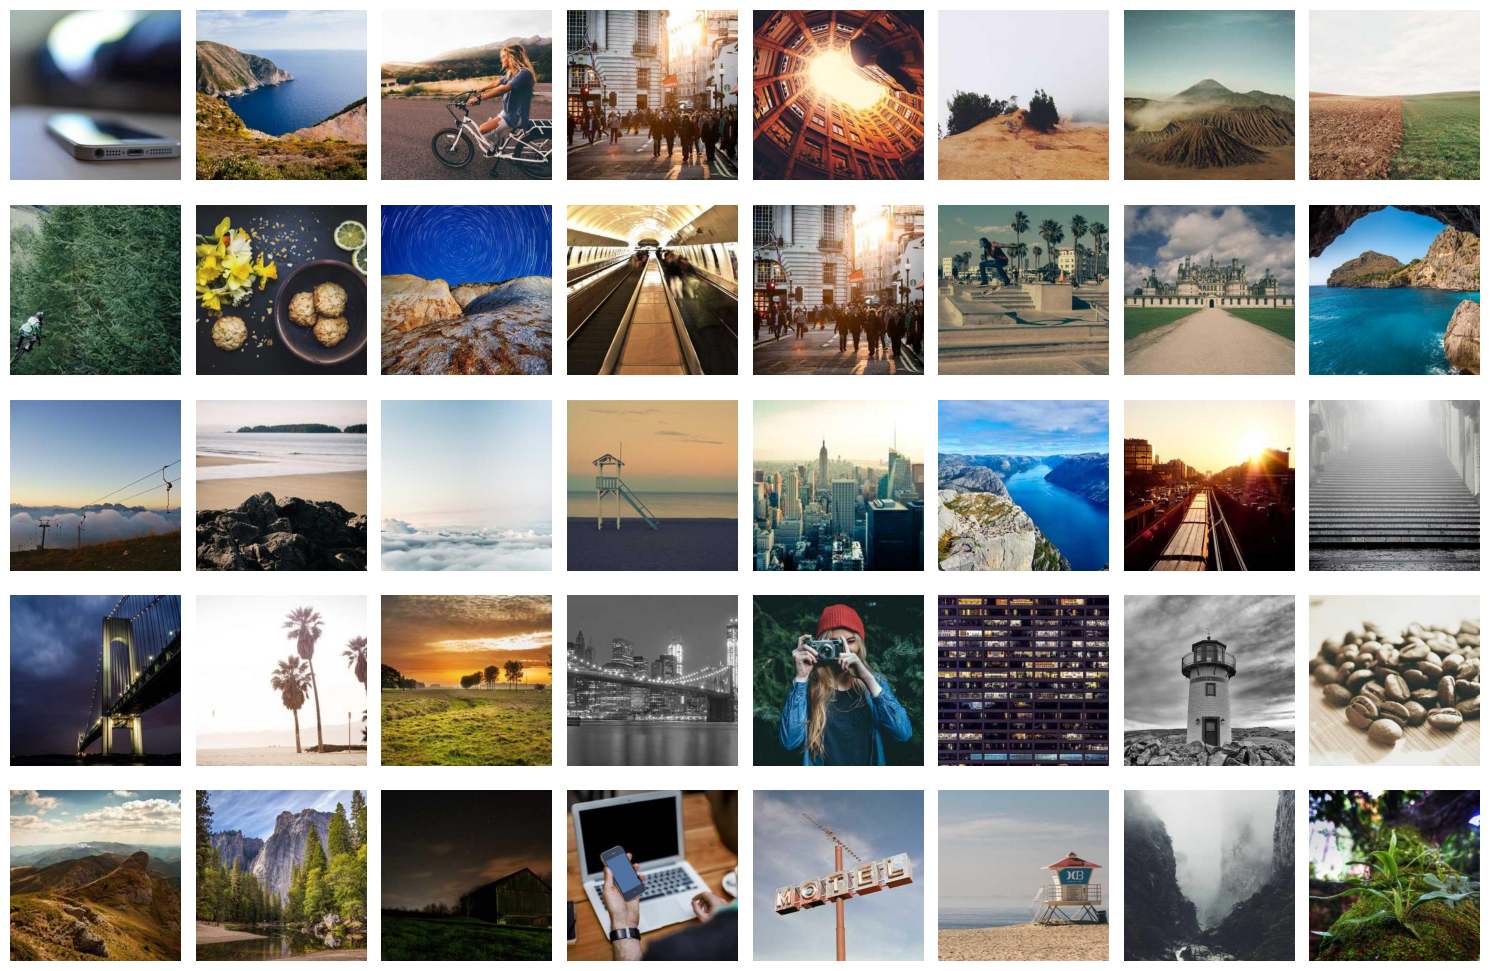

In [4]:
# Download random images from Picsum
for i in range(40):
    url = f"https://picsum.photos/seed/{i+20}/400/400"  
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        img.save(f"data_tcav/random//img_{i}.jpg")
        print(f"Saved img_{i}.jpg")
    else:
        print(f"Failed to download image {i}")

        
preview_image("data_tcav/random")

## Target images

In [5]:
# Download a car specific dataset from Kaggle 

path = kagglehub.dataset_download("prondeau/the-car-connection-picture-dataset")
destination_dir = "/path/to/your/target/directory"

print("Path to dataset files:", path)
all_files = os.listdir(path)
print(len(all_files))

Path to dataset files: /home/raph2268/.cache/kagglehub/datasets/prondeau/the-car-connection-picture-dataset/versions/1
0


300 randomly selected files moved, and the rest removed.


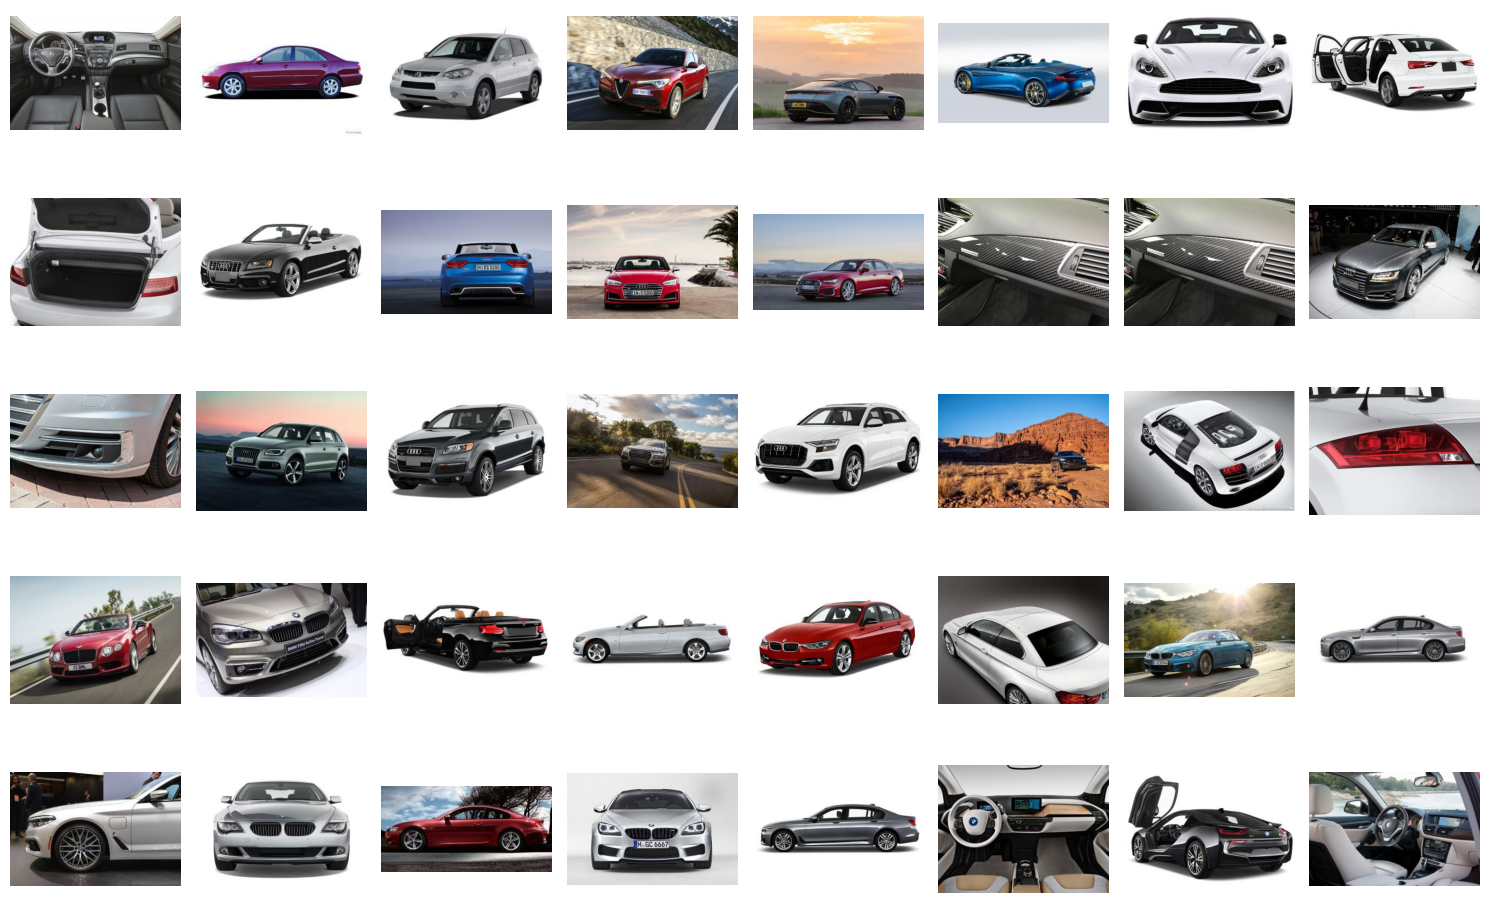

In [6]:
destination_dir = 'data_tcav/targets/car'
# Randomly select 300 files to keep (or however many are available)

num_files_to_keep = 300
files_to_keep = random.sample(all_files, min(num_files_to_keep, len(all_files)))

# Loop through the files and move or delete them
for file_name in all_files:
    file_path = os.path.join(path, file_name)
    
    if file_name in files_to_keep:
        # Move the selected file to the destination directory
        shutil.move(file_path, os.path.join(destination_dir, file_name))
    else:
        # Remove the files you don't want
        os.remove(file_path)

print("300 randomly selected files moved, and the rest removed.")

preview_image("data_tcav/targets/car")

## Concept set

For this set, you just select images on the internet manually (or generate them using your favorite VLM).

This is the major downside of this method. 

Improvement have been done to generate those images using automatically VLMs in [(Md Imran Hossain, 2024)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10600856)

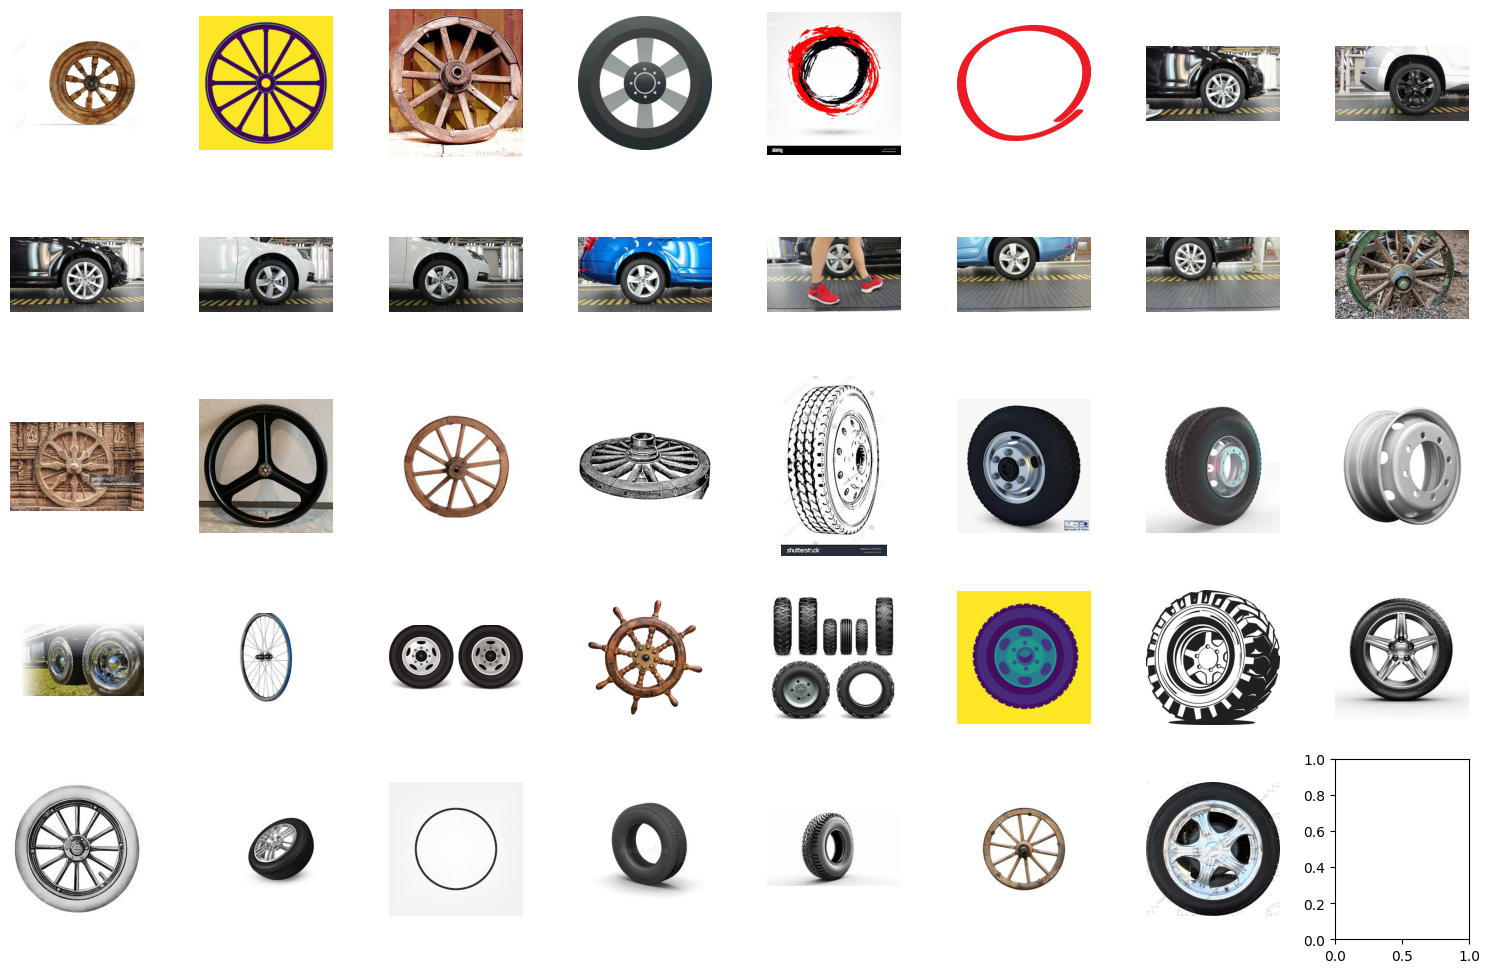

In [7]:
preview_image("data_tcav/concepts/wheel")

# Model

For this tutorial we are going to use resnet50, and for the class inspected, we use #817 namely sports car, sport car


In [8]:
model = models.resnet50(pretrained=True)
model.eval()

/home/raph2268/anaconda3/envs/XAI/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raph2268/anaconda3/envs/XAI/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Making sure the we pass the correct input size to the model
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img).unsqueeze(0)# shape: [1, 3, 224, 224]

## Build the CAV



In [ ]:
# We first load the model and pick a layer to hook into
model = models.resnet50(pretrained=True).eval()
target_layer = model.layer4  # pick your layer

# Then we use captum to capture the activations because it is not doable with the current PyTorch version
layer_activations = []

def activation_hook(output):
    layer_activations.append(output.detach())   

hook_handle = target_layer.register_forward_hook(activation_hook)

In [ ]:


def get_activations(image_paths):
    activations = []
    for path in image_paths:
        layer_activations.clear()
        input_tensor = load_image(path)
        with torch.no_grad():
            _ = model(input_tensor)  # triggers hook
        act = layer_activations[0].squeeze(0)  # shape (C, H, W)
        pooled = act.mean(dim=(1, 2))  # Global Average Pooling → shape (C,)
        activations.append(pooled.numpy())
    return np.array(activations)

In [12]:
# Defining the paths to the images
concept_image_paths = glob.glob("data_tcav/concepts/wheel/*.jpg")
random_image_paths = glob.glob("data_tcav/random/*.jpg" )
target_image_paths = glob.glob("data_tcav/targets/car/*.jpg")

# Extract the embedding of the concept and random images
concept_acts = get_activations(concept_image_paths)
random_acts = get_activations(random_image_paths)

# Run the classifier between those two embeddings
X = np.concatenate([concept_acts, random_acts])
y = np.array([1] * len(concept_acts) + [0] * len(random_acts))

clf = SGDClassifier(alpha=0.01, max_iter=1000)
clf.fit(X, y)

cav = clf.coef_[0]

In [13]:
hook_handle.remove()

## Compute TCAV

In [14]:
def compute_tcav_score(model, cav, image_paths, class_idx, layer):
    model.eval()
    scores = []
    lga = LayerGradientXActivation(model, layer)
    
    for path in image_paths:
        input_tensor = load_image(path)
        input_tensor.requires_grad = True

        attr = lga.attribute(input_tensor, target=class_idx)  # shape: (1, C, H, W)
        attr = attr.squeeze(0).mean(dim=(1, 2))  # Global avg pool → (C,)

        score = np.dot(attr.detach().cpu().numpy(), cav)
        scores.append(score > 0)

    return np.mean(scores)

In [15]:
tcav_score = compute_tcav_score(model, cav, target_image_paths, class_idx=817, layer=target_layer)  # 817 = class index for 'car' in ImageNet
print("TCAV score for 'car' class and 'wheel' concept:", tcav_score)


TCAV score for 'car' class and 'wheel' concept: 1.0


In [16]:
def compute_tcav_per_image_scores_captum(model, image_paths, class_index, cav, layer):
    model.eval()
    image_scores = []

    # Captum object to get gradient * activation
    lga = LayerGradientXActivation(model, layer)

    for path in image_paths:
        input_tensor = load_image(path)
        input_tensor.requires_grad = True

        # Compute gradient * activation
        grad_x_act = lga.attribute(input_tensor, target=class_index)  # (1, C, H, W)

        # Global average pooling over H and W
        grad_x_act_vec = grad_x_act.squeeze(0).mean(dim=(1, 2)).detach().cpu().numpy()  # shape: (C,)

        # Directional derivative = dot with CAV
        directional_derivative = np.dot(grad_x_act_vec, cav)
        image_scores.append((path, directional_derivative))

    return image_scores

In [17]:
def plot_tcav_scores(image_scores, top_n=8):
    fig, axes = plt.subplots(1, top_n, figsize=(4 * top_n, 4))
    
    for i, (img_path, score) in enumerate(sorted(image_scores, key=lambda x: -abs(x[1]))[:top_n]):
        img = Image.open(img_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"Score: {score:.2f}", fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

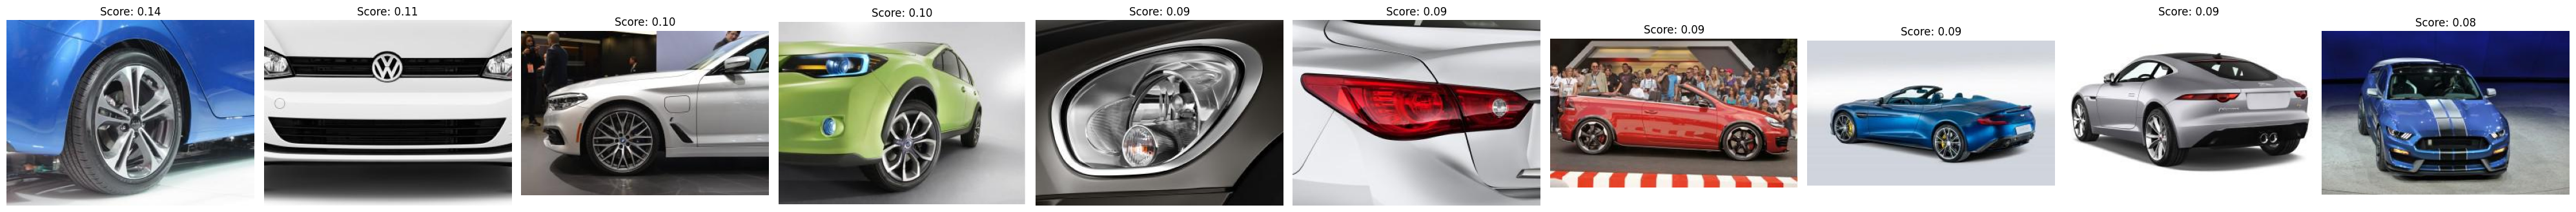

In [18]:
image_scores = compute_tcav_per_image_scores_captum(model, target_image_paths, 817, cav, target_layer)

plot_tcav_scores(image_scores, top_n=10)